![Matplotlib logo](img/matplotlib.svg)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.training import *
from src.matplotlib_exercises import *

# Time Series

We have already seen that Pandas does a pretty good job of handling plots with datetime axes in an automated fashion.  But all of that control relies on underlying Matplotlib features that we will look at within the the latter library.

As an example for this module, we will use some very old data that was collected by Brad Huntting and used with co-author, and contributor to this training material, David Mertz, for an article on the [R Programming Language](http://gnosis.cx/publish/programming/R.html).

This data is temperature readings at approximately 3 minute intervals, over about a year, from Brad's house in Boulder, Colorado USA, in 2003-2004.  We would like to use data that has a greater sample frequency than the daily frequency that other examples have used.  As it usually goes with real-world data, the first step is a little bit of cleanup.  Firstly we have to handle the on-disk data format, which looks like this:

```
% zcat outside.gz | head -3
2003 07 25 16 04 27.500000
2003 07 25 16 07 27.300000
2003 07 25 16 10 27.300000
```

It does not take much Python code to read the files and cast the dates and value in ℃.  We have four files with measurements in different locations.  We construct a Python dictionary first for each location (mapping datetime to measure).  Once constructed, we decide to collect the aggregation in a Pandas DataFrame; but you can see that the parsing code does not require Pandas.

In [2]:
import gzip
from datetime import datetime

def brad_house():
    df = pd.DataFrame()
    for location in ['basement', 'lab', 'livingroom', 'outside']:
        with gzip.open('data/%s.gz' % location) as f:
            readings = dict()
            for line in f:
                Y, m, d, H, M, temp = line.split()
                readings[datetime(*map(int, (Y, m, d, H, M)))] = float(temp)
        df[location] = pd.Series(readings)

    return df.sort_index()

In [3]:
df = brad_house()
df

,basement,lab,livingroom,outside
2003-07-25 16:04:00,24.0,NaN,29.8,27.5
2003-07-25 16:07:00,24.0,NaN,29.8,27.3
2003-07-25 16:10:00,24.0,NaN,29.8,27.3
2003-07-25 16:13:00,24.1,NaN,29.8,27.4
2003-07-25 16:16:00,24.1,NaN,29.8,27.8
...,...,...,...,...
2004-07-16 15:16:00,21.7,22.9,22.8,16.8
2004-07-16 15:19:00,21.7,22.9,22.8,16.9
2004-07-16 15:22:00,21.7,22.9,22.8,16.8
2004-07-16 15:25:00,21.7,22.9,22.8,16.8


We see from the first few rows that some data is missing.  Perhaps there were some timestamps where all four sensors were down simultaneously.  Pandas can take care of assuring uniform time intervals easily enough. This adds about 1% to the number of observation rows, and we will back fill values to avoid NaNs (decide in a problem-specific way whether filling/interpolation is good).

In [4]:
# T for minutes because M is taken for months
df = df.asfreq('3T').bfill()
df

,basement,lab,livingroom,outside
2003-07-25 16:04:00,24.0,25.2,29.8,27.5
2003-07-25 16:07:00,24.0,25.2,29.8,27.3
2003-07-25 16:10:00,24.0,25.2,29.8,27.3
2003-07-25 16:13:00,24.1,25.2,29.8,27.4
2003-07-25 16:16:00,24.1,25.2,29.8,27.8
...,...,...,...,...
2004-07-16 15:16:00,21.7,22.9,22.8,16.8
2004-07-16 15:19:00,21.7,22.9,22.8,16.9
2004-07-16 15:22:00,21.7,22.9,22.8,16.8
2004-07-16 15:25:00,21.7,22.9,22.8,16.8


## Using Pandas

Let us first look at the basic wrapper Pandas gives us with almost no work; especially since we decided to use a DataFrame as our data structure.

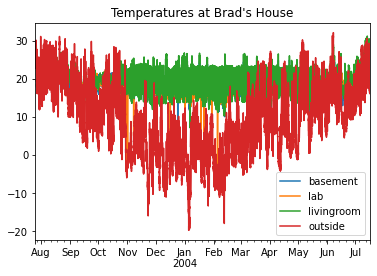

In [5]:
df.plot(title="Temperatures at Brad's House");

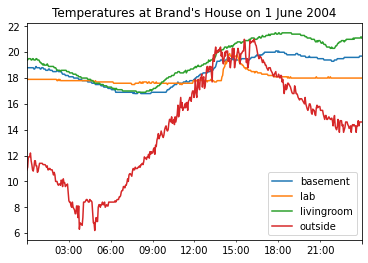

In [6]:
df.loc['2004-06-01'].plot(title="Temperatures at Brand's House on 1 June 2004");

Not surprisingly, outdoor temperatures see more fluctuation both over a day and over a year than do indoor ones.  But different interior rooms also have different regulation.

## Just Matplotlib

In recent years, Matplotlib has itself started handling datetime values more automatically.  In earlier versions, more manual effort was needed to get axis labels and other elements to do sensible things with datetimes (but it has been *possible* for a great many years).

Note that in below examples we pull out the `.values` attribute of Pandas Series.  This is not necessary, but it enforces working with the underlying array rather than using any Pandas adornments.  Everything we do would equally work with plain Python lists, albeit more slowly generally.

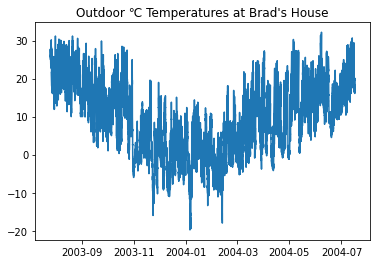

In [7]:
# A simple approach to plotting all temperatures for one location
fig, ax = plt.subplots()
# Reasonable selection of intermittent labels
ax.plot(df.index.values, df.outside.values)
ax.set_title("Outdoor ℃ Temperatures at Brad's House");

We get a cleaner picture by down sampling the data.  This is not particularly a Matplotlib operation, but it is worthing trying.

In [8]:
outside = df.outside.asfreq('d')
out_ts = outside.index.values
out_deg = outside.values
out_ts[:3], out_deg[:3]

(array(['2003-07-25T16:04:00.000000000', '2003-07-26T16:04:00.000000000',
        '2003-07-27T16:04:00.000000000'], dtype='datetime64[ns]'),
 array([27.5, 30.2, 17.8]))

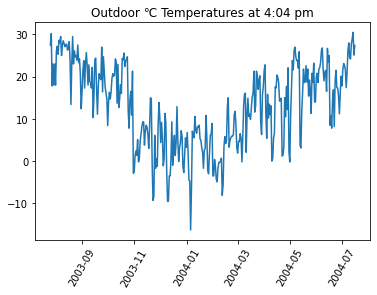

In [9]:
# Temperatures at 4:04 pm each day
fig, ax = plt.subplots()
ax.plot(out_ts, out_deg)
ax.tick_params(axis='x', rotation=60)
ax.set_title("Outdoor ℃ Temperatures at 4:04 pm");

We do less well in the defaults when we move to a lower resolution, such as one day.  The date is shown needlessly on the X ticks (although not the year).

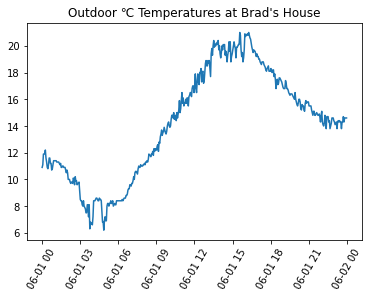

In [10]:
times = df.loc['2004-06-01'].index.values
temps = df.loc['2004-06-01'].outside.values
fig, ax = plt.subplots()
ax.plot(times, temps)
ax.tick_params(axis='x', rotation=60)
ax.set_title("Outdoor ℃ Temperatures at Brad's House");

We can do better in choosing useful labels for the X axis.  We will use intermittent axis labels with more details, and less detail for the minor labels. The gridlines can also be customized.

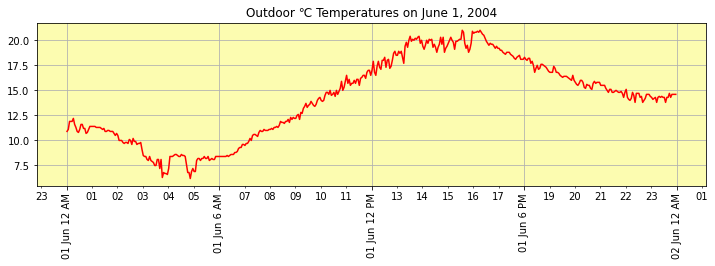

In [11]:
from matplotlib.dates import DateFormatter, HourLocator

fig, ax = plt.subplots(figsize=(12,3))
ax.set_facecolor('#FCFCB0')
ax.plot(times, temps, color="red")
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d %b %-I %p'))
ax.xaxis.set_minor_formatter(DateFormatter('%H'))
ax.tick_params(axis='x', rotation=90)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True)
ax.set_title("Outdoor ℃ Temperatures on June 1, 2004");

# Exercise

Create additional visualization involving the temperature data at Brad's house.  We would like to focus on tendencies over the whole year.  Use visualizations to draw conclusions about the following topics. Imagine this was the topic of a report for your supervisors or clients, and so you want to include effective visualizations for making your points.  For many of these, you may find it useful to use subplots to show comparative features of related data.

In [12]:
# Read the documentation about the dates submodule, 
# but these are some you may want to utilize
from matplotlib.dates import MonthLocator, WeekdayLocator, SATURDAY, SUNDAY

**Question:** Outdoor temperature is regulated only by climatological and meteorological factors, but indoor temperatures are also regulated by Brad's heating system(s).  

We do not know whether these systems are manually controlled or subject to one or more thermostats.  Based on trends in the data that we can visualize, in what manner do you hypothesize the temperature was controlled inside Brad's house?  Support your conclusion with reference to relevant plots.

In [13]:
brad = brad_house()

In [14]:
# Analysis and visualization here
...

**Question:** Assuming Brad uses one or more thermostats in his house, do the data suggest there was independent control of different zones of his house? Do the data suggest that he used timer-based thermostat controls that vary temperature by time-of-day? If so, does this apply to all zones of the house, or only some?

In [15]:
# Analysis and visualization here
...

**Question:** Based on the data, and more specifically on their visualization, do you have evidence that Brad modified his heating system(s), insulation, or other physical features of his house between summer 2003 and summer 2004.  If so, which zone(s) of his house were affected and how?

In [16]:
# Analysis and visualization here
...

**Question:** Let us stipulate that Brad generally worked outside his house during 2003-2004.  Therefore, he likely had less need for heat in the house during weekdays when he was out than during weekends when he was at home.  Do you believe he took any actions to reflect this difference in heating demand, based on the data and their visualization?|

In [17]:
# Analysis and visualization here
...